In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import json
import os
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

F:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def read_and_show_img(filepath):
    plt.figure(figsize = (30,30))
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

In [3]:
uav = "dataset/RGB/uav_images/"
sat = "dataset/RGB/sat_images/"
fsat = "dataset/RGB/false_sat_images/"

In [4]:
correct_names_sat = np.array(os.listdir(sat))
correct_names_uav = np.array(os.listdir(uav))
false_names = np.array(os.listdir(fsat))

In [5]:
seed = 13
np.random.seed(seed)

In [6]:
ctrain, ctest = train_test_split(correct_names_sat, test_size = 0.2, shuffle=True, random_state=seed)
ftrain, ftest = train_test_split(false_names, test_size = 0.2, shuffle=True, random_state=seed)

In [7]:
def create_correct_set(arr):
    return np.array([[uav + x, sat + x, 1] for x in arr])

def make_two_arrays(arr):
    r = np.array(arr, copy=True)
    l = np.array(arr, copy=True)
    np.random.shuffle(l)
    return r, l

def create_incorrect_same_category(arr, pref1, pref2, limit = 10000):
    r, l = make_two_arrays(arr)
    same = []
    res = []
    #maybe it's a little inefficient, but it doesn't impact performance of final solution so should be fine
    while len(r) > 1 or len(res) == 0 or len(res) >= limit:
        for i in range(len(r)):
            if r[i] != l[i]:
                res.append([pref1 + r[i], pref2 + l[i], 0])
                if len(res) == limit:
                    return np.array(res)
            else:
                same.append(r[i])
        r, l = make_two_arrays(same)
        same = []
    return np.array(res)

def create_correct_false_pairs(cvals, fvals, scale_factor, pref1, pref2):
    from_correct = np.array(list(cvals) * 3)
    fvalues = np.array(list(fvals) * (int(len(from_correct) / len(fvals)) + 1))
    #To make selection more smooth, same item can't be selected more than 1 time on the current dataset, so it forces to select different ones
    random_choices = np.random.choice(fvalues, len(from_correct), replace = False)
    return np.array([[pref1 + from_correct[i], pref2 + random_choices[i], 0] for i in range(len(random_choices))])

In [9]:
def getDfSplit(carr, farr, scale_one_correct, scale_no_correct):
    print("creating correct")
    correct = create_correct_set(carr)
    print("correct_number " + str(len(correct)))
    print("creating incorrect1")
    incorrect1 = create_incorrect_same_category(carr, uav, sat)
    print("icorrect1_number " + str(len(incorrect1)))
    print("creating incorrect2")
    incorrect2 = create_correct_false_pairs(carr, farr, scale_one_correct, uav, fsat)
    print("icorrect2_number " + str(len(incorrect2)))
    print("creating incorrect3")
    incorrect3 = create_incorrect_same_category(farr, fsat, fsat, len(correct) * scale_no_correct)
    print("icorrect3_number " + str(len(incorrect3)))
    print("Concatenating")
    resulting_array = np.concatenate((correct, incorrect1, incorrect2, incorrect3))
    print("concatenated_number " + str(len(resulting_array)))
    return pd.DataFrame(resulting_array, columns = ["path1", "path2", "label"])

In [10]:
df_train = getDfSplit(ctrain, ftrain, 3, 9)
df_test = getDfSplit(ctest, ftest, 3, 9)

creating correct
correct_number 340
creating incorrect1
icorrect1_number 339
creating incorrect2
icorrect2_number 1020
creating incorrect3
icorrect3_number 3060
Concatenating
concatenated_number 4759
creating correct
correct_number 85
creating incorrect1
icorrect1_number 84
creating incorrect2
icorrect2_number 255
creating incorrect3
icorrect3_number 765
Concatenating
concatenated_number 1189


In [8]:
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [9]:
# check for similarities
sift = cv2.SIFT_create()
img1 = cv2.imread(uav+"DJI_0650.JPG", 0)
img2 = cv2.imread(sat + "DJI_0650.JPG", 0)
img1 = cv2.resize(img1, (224, 224)) 
img2 = cv2.resize(img2, (224, 224)) 
# check keypoints and descriptions of images
kp_1,desc_1 = sift.detectAndCompute(img1,None)
kp_2,desc_2 = sift.detectAndCompute(img2,None)

In [10]:
index_params = dict(algorithm=0, trees=2)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc_1, desc_2, k=2)
print(len(matches) / max(len(kp_1), len(kp_2)))

0.6619469026548672


In [11]:
result = cv2.drawMatchesKnn(img1,kp_1,img2,kp_2,matches,None)

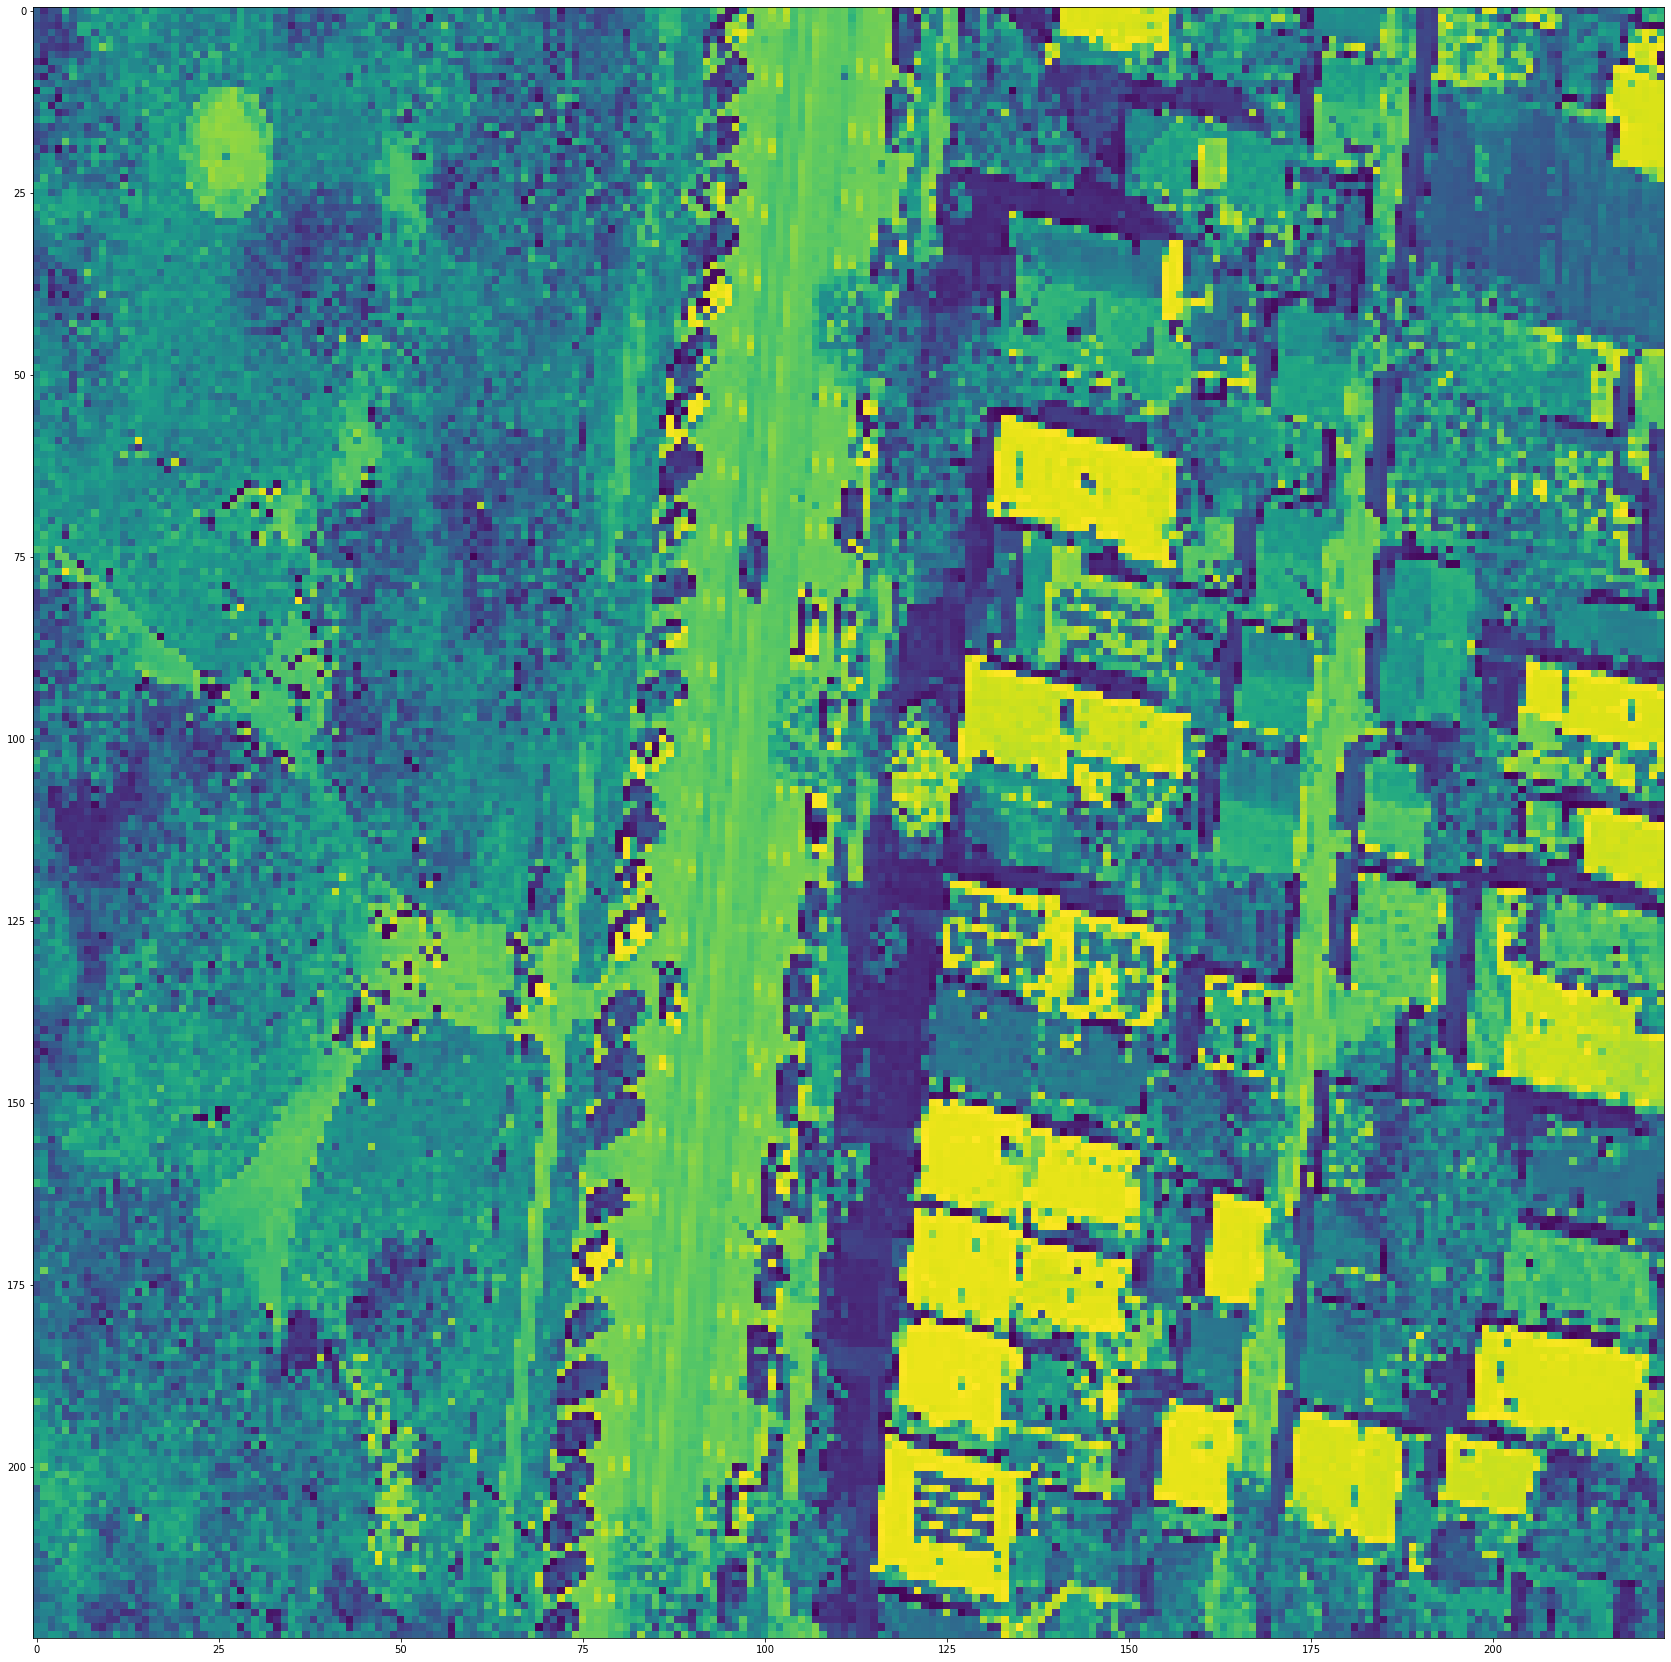

In [12]:
plt.figure(figsize = (30,30))

plt.imshow(img2)
plt.show()

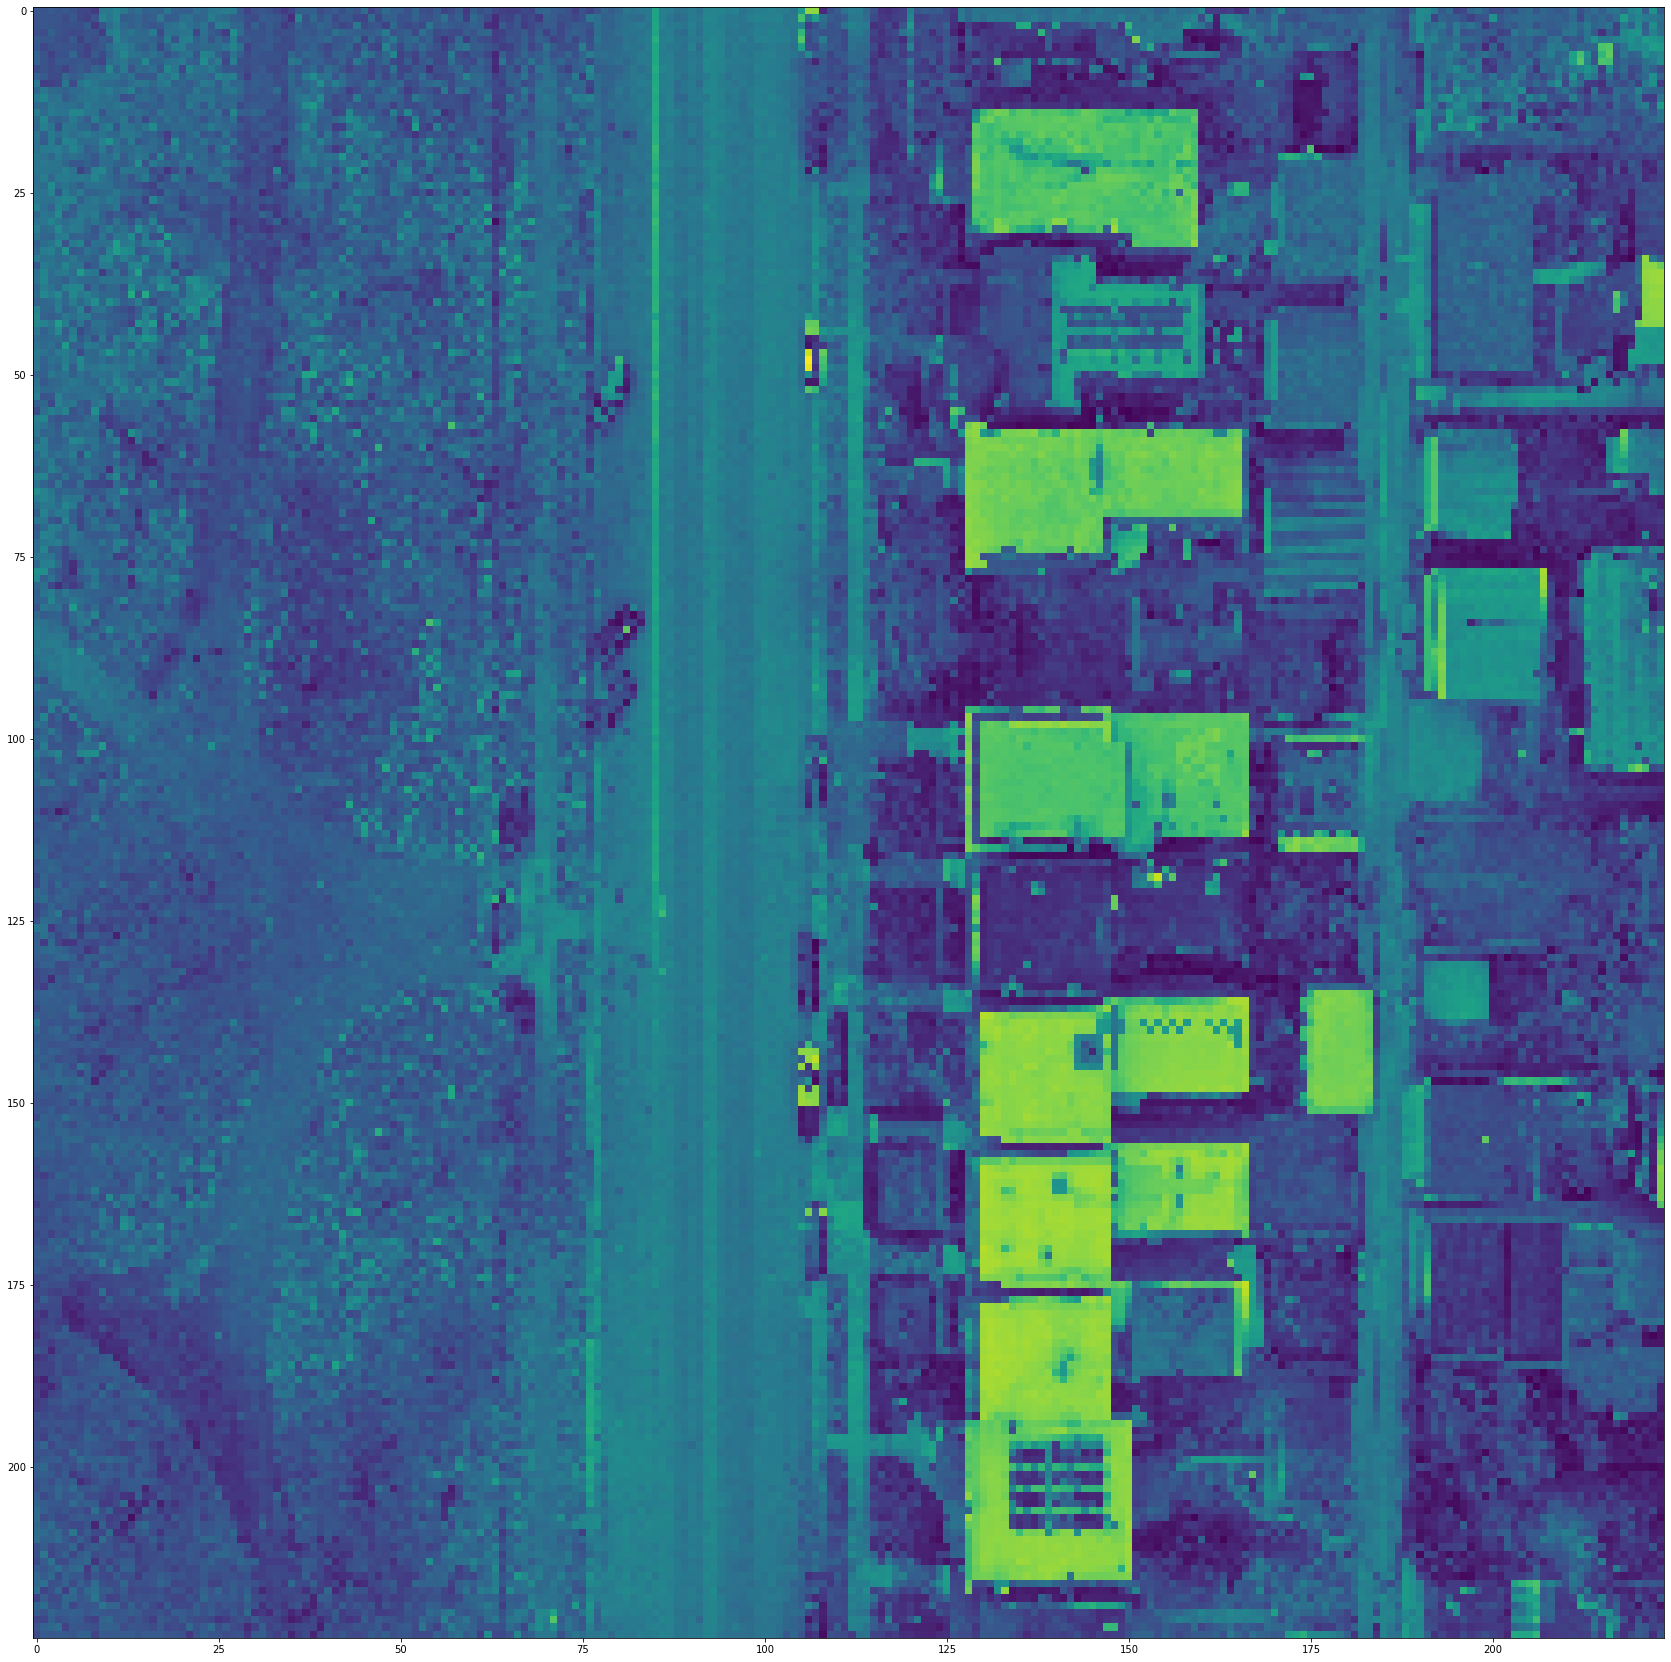

In [13]:
plt.figure(figsize = (30,30))
plt.imshow(img1)
plt.show()

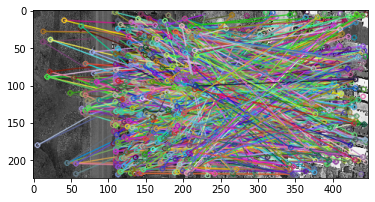

In [14]:
plt.imshow(result)

In [19]:
# check for similarities
sift = cv2.SIFT_create()
img1 = cv2.imread(uav+"DJI_0650.JPG", 0)
img2 = cv2.imread(uav + "DJI_0651.JPG", 0)
img1 = cv2.resize(img1, (224, 224)) 
img2 = cv2.resize(img2, (224, 224)) 
# check keypoints and descriptions of images
kp_1,desc_1 = sift.detectAndCompute(img1,None)
kp_2,desc_2 = sift.detectAndCompute(img2,None)
index_params = dict(algorithm=0, trees=2)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc_1, desc_2, k=2)

In [20]:
len(matches) / max(len(kp_1), len(kp_2))

1.0

In [21]:
len(kp_1)

374

In [62]:
def resize_image(image, target_size=(224, 224)):
    return cv2.resize(image, target_size)

def normalize_image(image):
    # Apply histogram equalization for contrast stretching
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

def gamma_correction(image, gamma=1.0):
    # Build a lookup table mapping the pixel values [0, 255] to their adjusted values
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # Apply the lookup table to the image
    return cv2.LUT(image, table)

def draw_cross_keypoints(img, keypoints, color):
    """ Draw keypoints as crosses, and return the new image with the crosses. """
    img_kp = img.copy()  # Create a copy of img

    # Iterate over all keypoints and draw a cross on evey point.
    for kp in keypoints:
        x, y = kp.pt  # Each keypoint as an x, y tuple  https://stackoverflow.com/questions/35884409/how-to-extract-x-y-coordinates-from-opencv-cv2-keypoint-object

        x = int(round(x))  # Round an cast to int
        y = int(round(y))

        # Draw a cross with (x, y) center
        cv2.drawMarker(img_kp, (x, y), color, markerType=cv2.MARKER_CROSS, markerSize=5, thickness=1, line_type=cv2.LINE_8)

    return img_kp  # Return the image with the drawn crosses.


def check_same_object(img1_path, img2_path):
    # Load images
    img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

    img1 = resize_image(img1)
    img2 = resize_image(img2)
    
    img1 = gamma_correction(img1, 1.5)
    img2 = gamma_correction(img2, 1.5)
    
    
    img1 = normalize_image(img1)
    img2 = normalize_image(img2)
    
    plt.figure(figsize = (30,30))
    plt.imshow(img1, cmap='gray')
    plt.show()
    
    plt.figure(figsize = (30,30))
    plt.imshow(img2, cmap='gray')
    plt.show()
    # Create SIFT object
    sift = cv2.SIFT_create(sigma = 5, contrastThreshold=0.1, edgeThreshold=10)
    fast = cv2.FastFeatureDetector_create(threshold=30)
    orb = cv2.ORB_create(500)
    
    # Find keypoints and descriptors for each image
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    #img_kp = cv2.drawKeypoints(img, keypoints, cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(120,157,187))
    img_kp1 = draw_cross_keypoints(img1, keypoints1, color=(120,157,187))  # Draw keypoints as "+" signs
    cv2.imwrite("img1.jpg", img_kp1)

    # Create FLANN based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
    search_params = dict(checks=1000)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    #FLANN_INDEX_LSH = 6
    #index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, 
    #                   key_size = 12, multi_probe_level = 1)
    #search_params = dict()

    #flann = cv2.FlannBasedMatcher(index_params,search_params)
    # Match descriptors
    #matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    matches = bf.match(descriptors1,descriptors2)
    matches = sorted(matches, key = lambda x:x.distance)
    distances = [m.distance for m in matches]
    distance = sum(distances) / len(distances)
    # If distance == 0 -> similarity = 1
    similarity = 1 / (1 + distance)
    return similarity
    # Apply Lowe's ratio test
    #good_matches = []
    #for m, n in matches:
     #   print("%.1f" % (m.distance))
      #  print("%.1f" % (n.distance))
      #  if m.distance < 0.01 * n.distance:
      #      good_matches.append(m)

    # Minimum number of matches required to consider images depicting the same object
    #MIN_MATCH_COUNT = 10
    #print(len(good_matches))

    # Check if enough good matches are found
    #if len(good_matches) >= MIN_MATCH_COUNT:
    #    return True
    #else:
    #    return False



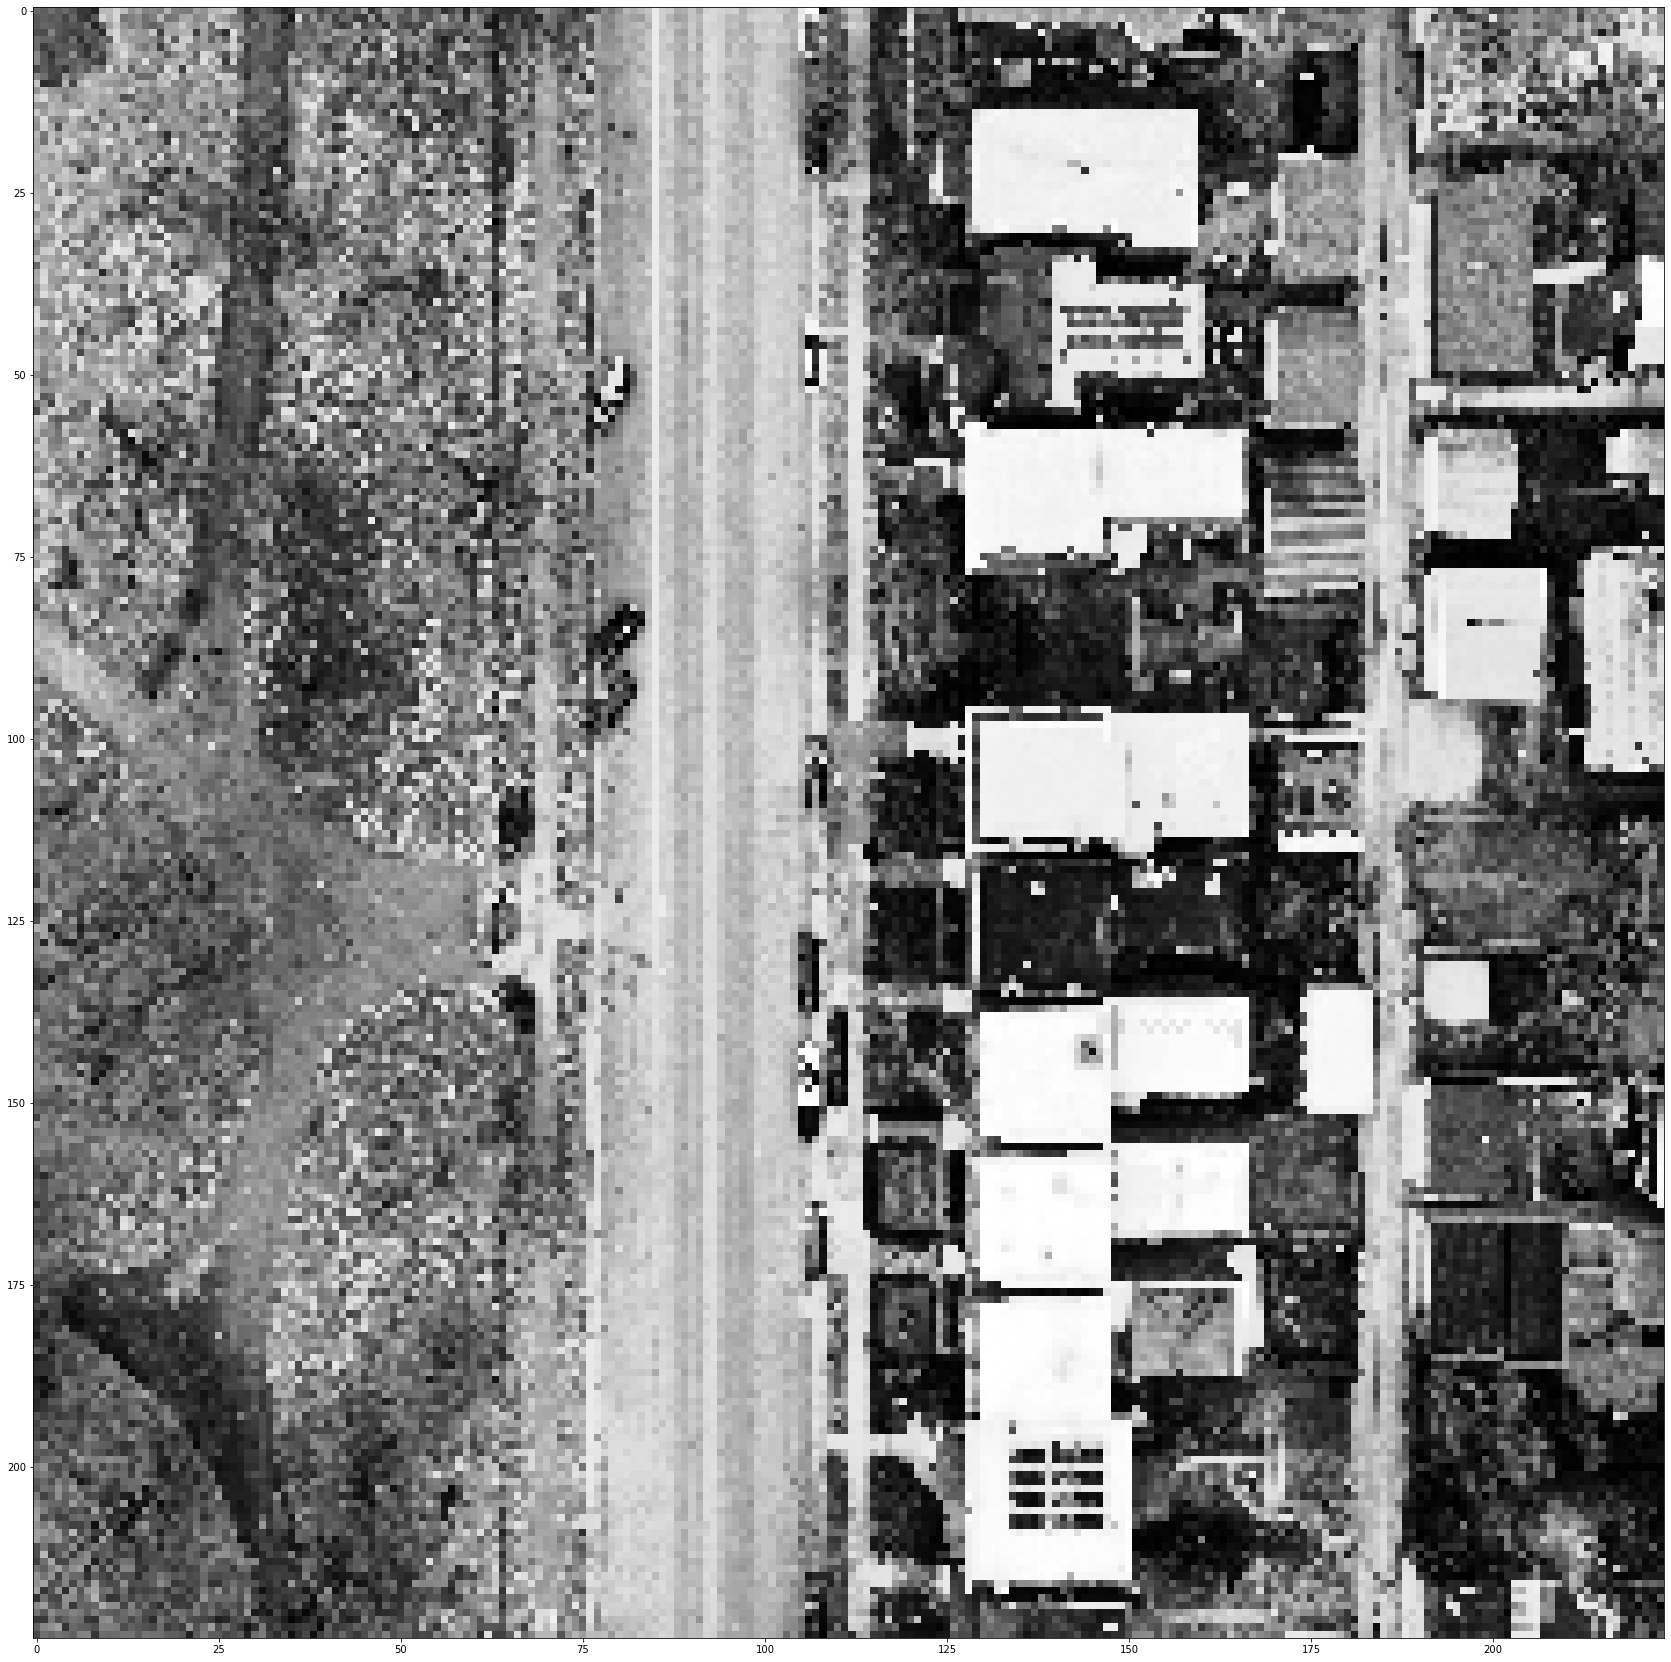

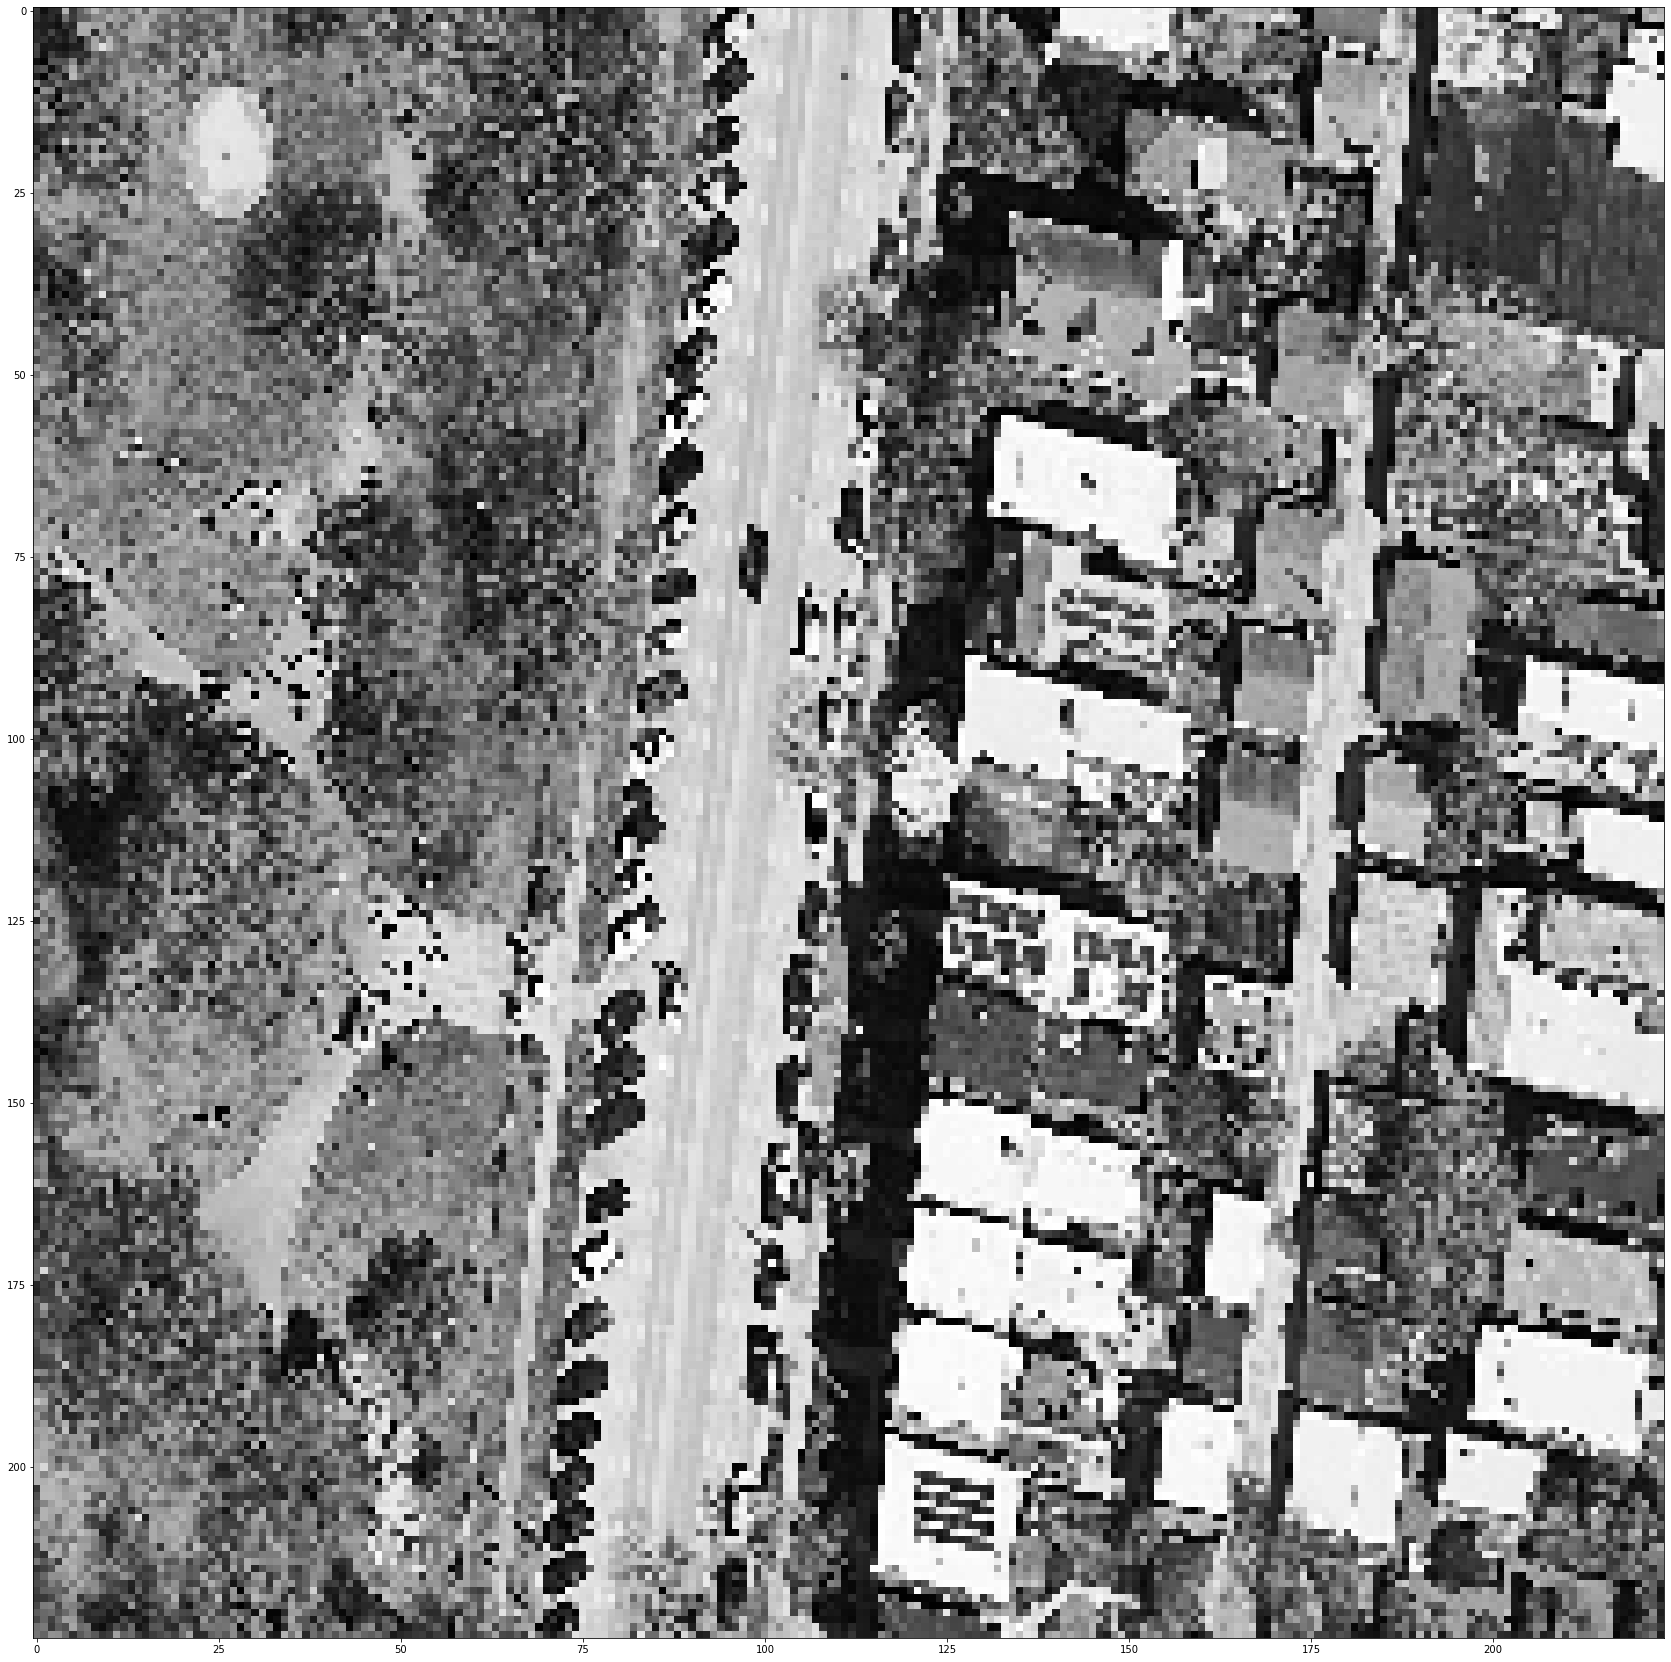

0.003035090400011442


In [63]:
# Example usage
img1_path = uav + "DJI_0650.JPG"
img2_path = sat + "DJI_0650.JPG"
print(check_same_object(img1_path, img2_path))

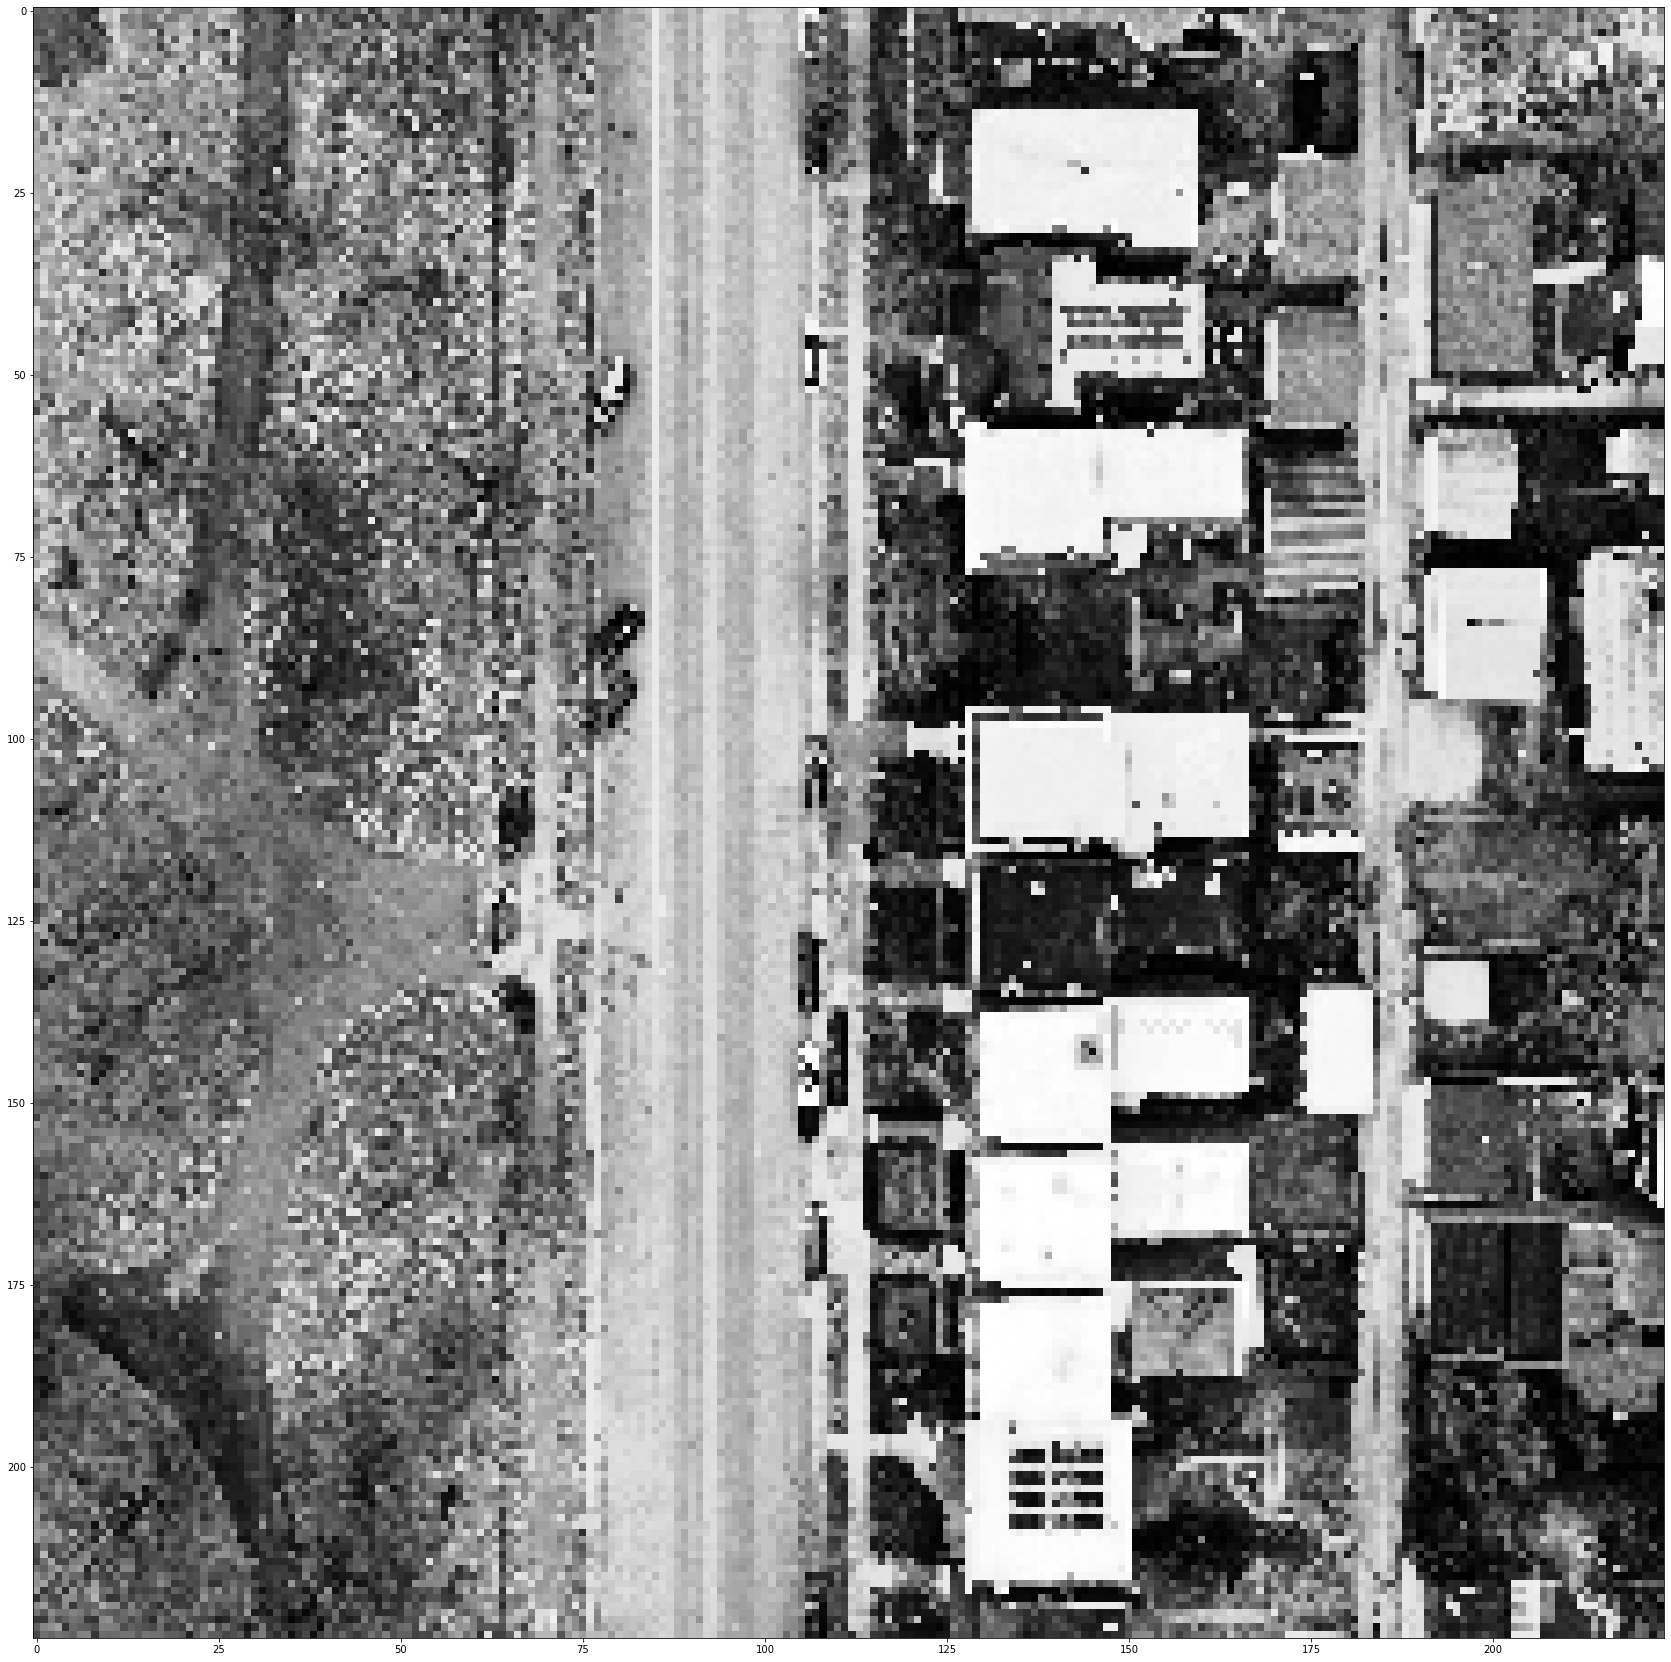

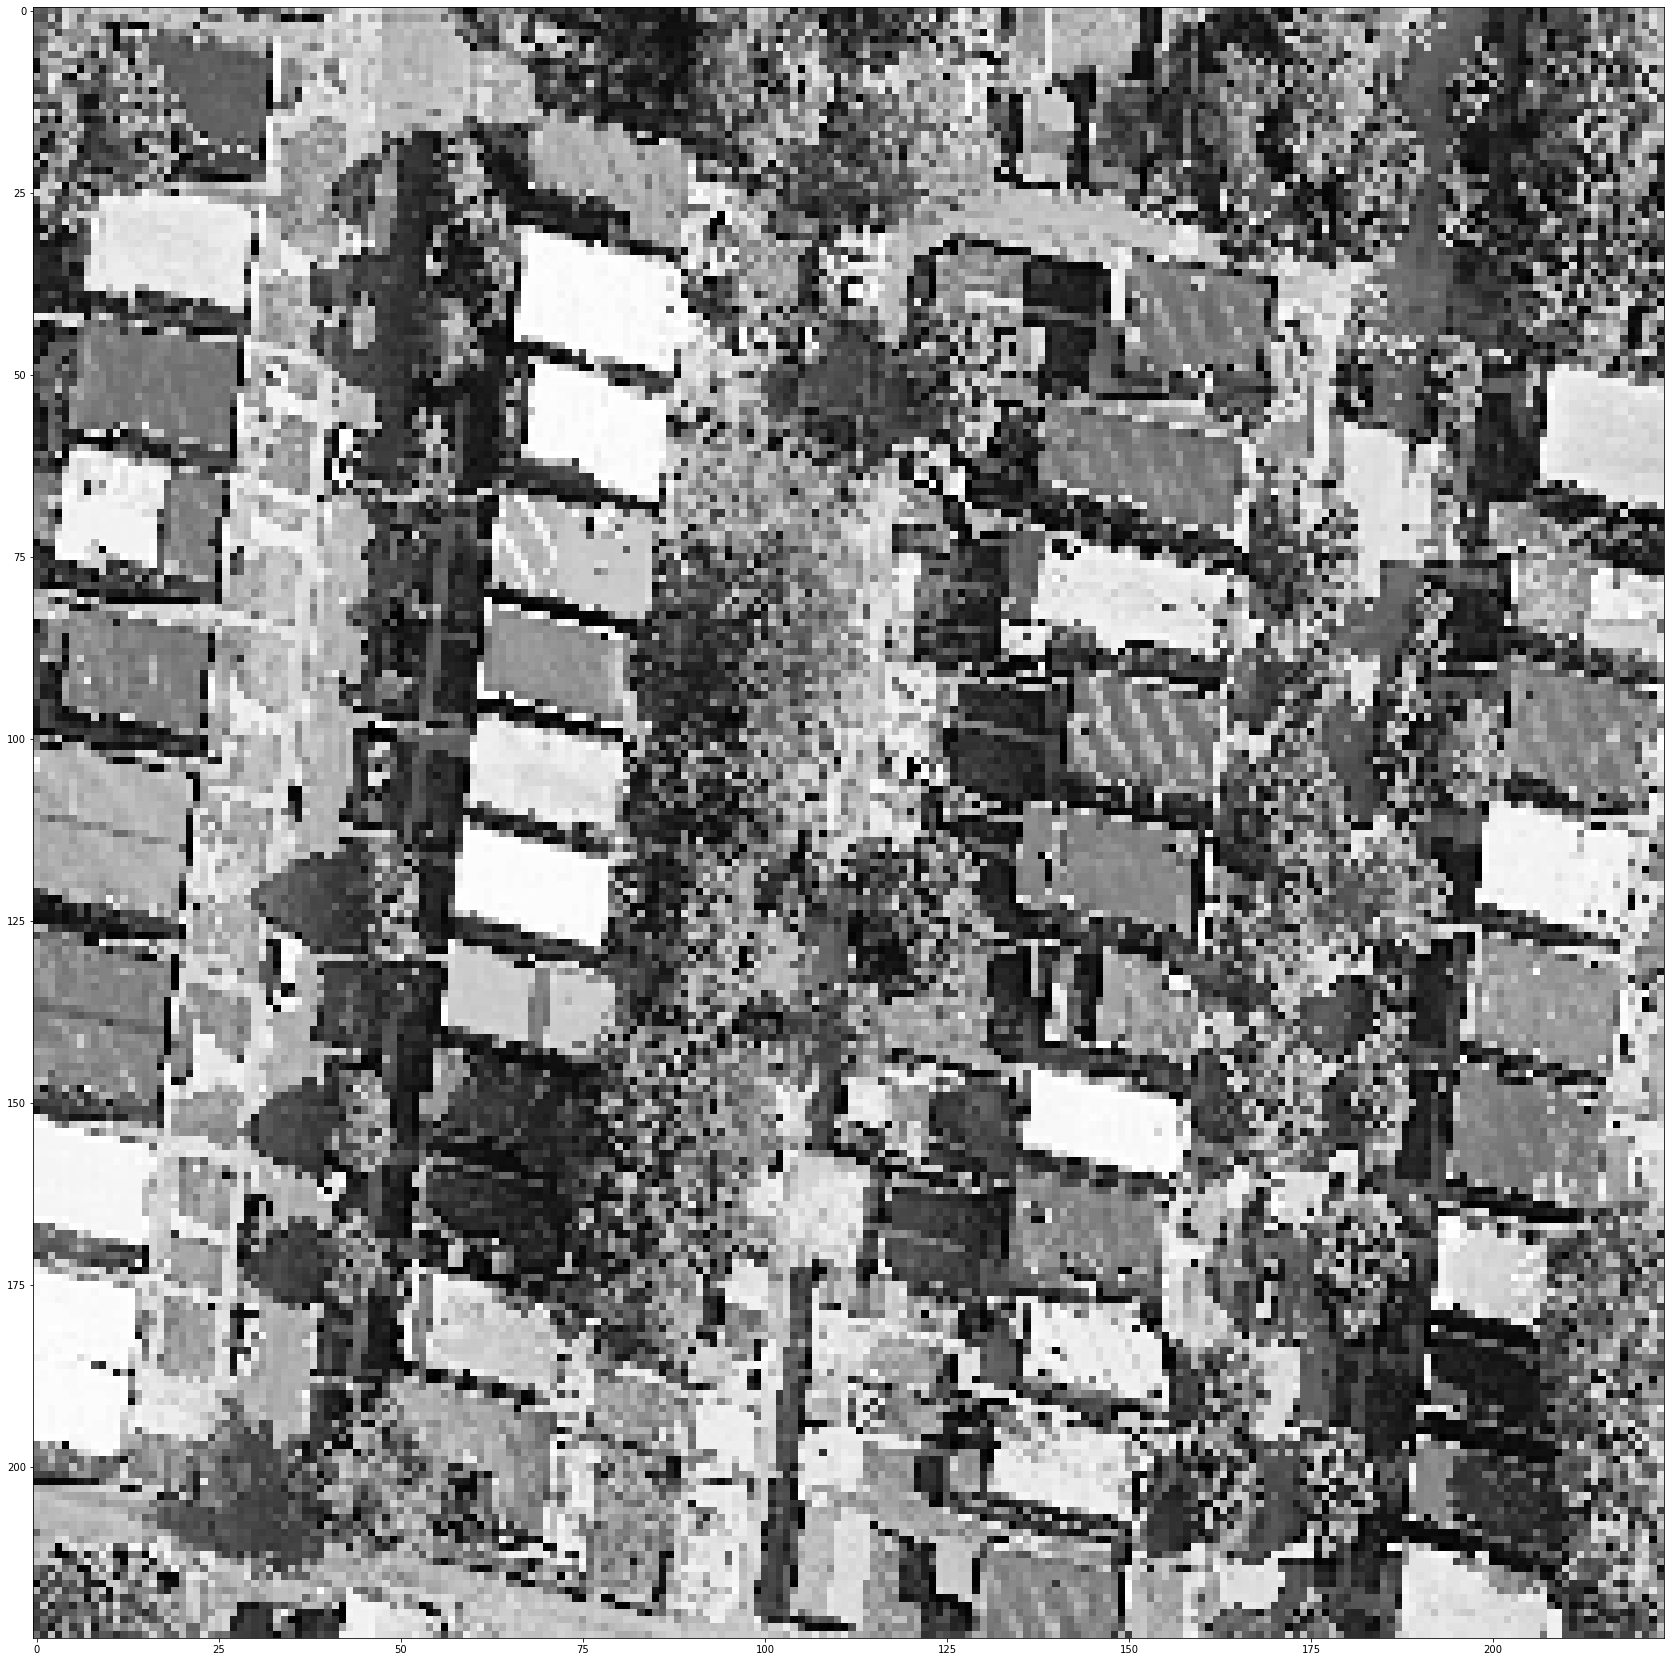

0.0028831872547778253


In [64]:
# Example usage
img1_path = uav + "DJI_0650.JPG"
img2_path = fsat + "(38.5850297263517,-90.23695492199), (38.58408787960666, -90.23515501774955).jpg"
print(check_same_object(img1_path, img2_path))